# Notebook 1: Data Retrieval and Preprocessing

This notebook serves as a guide to accesing open source weather data and using it. In the first part, it demonstrates the visualisation of median ensembles of precipittion aggragated over 3 hours.


## Accessing Data
To access the data, import the following libraries.

In [3]:
from pathlib import Path

import xarray as xr
import numpy as np
import os
os.environ["ECCODES_DIR"] = "/home/nen/micromamba/envs/eccodes_env"
import eccodes
import matplotlib.pyplot as plt

from meteodatalab import data_source, grib_decoder
from meteodatalab.operators import time_operators as time_ops
from meteodatalab.operators.support_operators import get_grid_coords
from cartopy import crs as ccrs, feature as cfeature

### Define Source
Use the next command to define the source to request the data from. In this cas it is a local file.

In [4]:
source = data_source.FileDataSource(datafiles=["precip_20250122_06.grib"])
source

FileDataSource(request_template={}, datafiles=['precip_20250122_06.grib'])

### Retrieving Data
Use query functions to retrieve the reqired data in Xarray format and display its output.

In [5]:
request = {"param":["TOT_PREC"]}
ds_in = grib_decoder.load(source,request)
ds_in

{'TOT_PREC': <xarray.DataArray (eps: 10, ref_time: 1, lead_time: 4, y: 786, x: 1170)> Size: 147MB
 array([[[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           ...,
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
          [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
 

## Data Preprocessing

### Data Aggregation
Aggregate precipitation over 2-hour intervals.

In [6]:
tot_prec_2h = time_ops.delta(ds_in["TOT_PREC"], np.timedelta64(2,"h"))
ds_in["TOT_PREC"].lead_time

<xarray.DataArray 'lead_time' (lead_time: 4)> Size: 32B
array([             0,  3600000000000,  7200000000000, 10800000000000],
      dtype='timedelta64[ns]')
Coordinates:
  * lead_time  (lead_time) timedelta64[ns] 32B 00:00:00 01:00:00 ... 03:00:00

### Ensemble Calculation
Compute median ensembles using the preprocessed data.

In [7]:
data = tot_prec_2h.isel(lead_time=3).median(dim="eps").clip(min=0)
data.attrs["geography"] = tot_prec_2h.geography

### Plotting
Use predefined function <em> plot_utils </em> to plot the data or execute these steps.

Text(0.5, 1.0, 'Total Precipitation over last 2 hours from lead time 3')

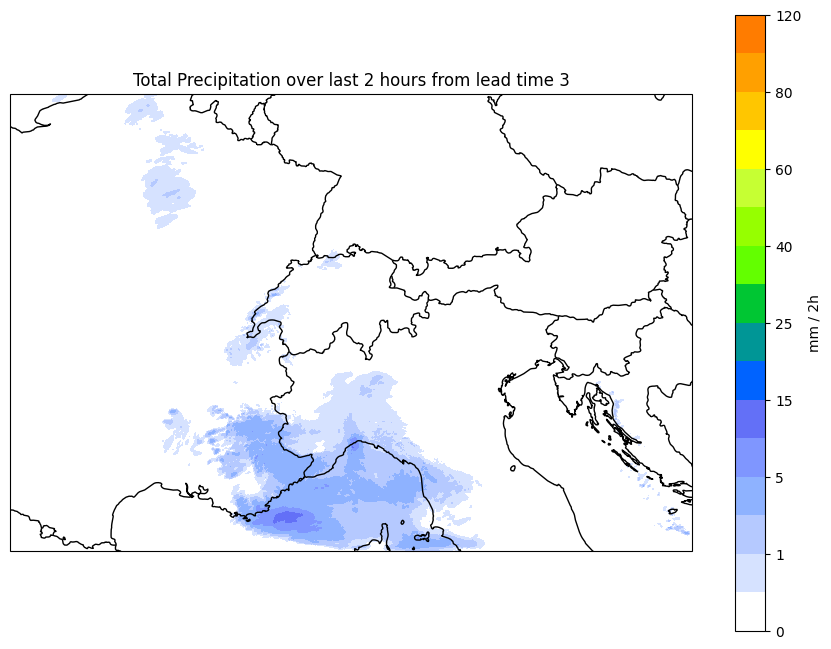

In [9]:
geo = data.geography

pol_lat = -1 * geo["latitudeOfSouthernPoleInDegrees"]
pol_lon = (geo["longitudeOfSouthernPoleInDegrees"] - 180) % 360
crs = ccrs.RotatedPole(pole_longitude=pol_lon, pole_latitude=pol_lat)

fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(1,1,1,projection=crs)

nx = geo["Ni"]
ny = geo["Nj"]

angle = geo["longitudeOfFirstGridPointInDegrees"]
lon_min = np.fmod(angle + 180, 360) - 180
lat_min = geo["latitudeOfFirstGridPointInDegrees"]

dlon = geo["iDirectionIncrementInDegrees"]
dlat = geo["jDirectionIncrementInDegrees"]

x = get_grid_coords(nx, lon_min, dlon, "x")
y = get_grid_coords(ny, lat_min, dlat, "y")

file_path = "colormap.txt"
path = Path(os.path.abspath(file_path))
with path.open() as f:
    it = iter(f)
    for _ in range(3):
        next(it)
    levels = [0.0] + [float(v) for v in next(it).split(" ")]
    colors = [tuple(int(v) / 255 for v in line.split(" ") if v) for line in it]

c = ax.contourf(
    x, y, data.values[0], transform=crs, levels=levels, colors=colors
)
fig.colorbar(c, label="mm / 2h")

ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

ax.set_title("Total Precipitation over last 2 hours from lead time 3")
